# Block image Classification 

## Model Training

In [21]:
import numpy as np

import keras
from keras import layers

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [22]:
# Dataset from: https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files

In [23]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='Pokemon/train',
  labels='inferred',
  label_mode='int', # !!! ‘categorical' when using sparse_categorical_crossentropy loss !!!
  batch_size=12,
  image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory='Pokemon/val',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))




Found 377 files belonging to 3 classes.
Found 377 files belonging to 3 classes.


In [24]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [25]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 32
Number of validation batches: 26
Number of test batches: 6


2024-05-18 16:25:26.162558: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:27.438319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


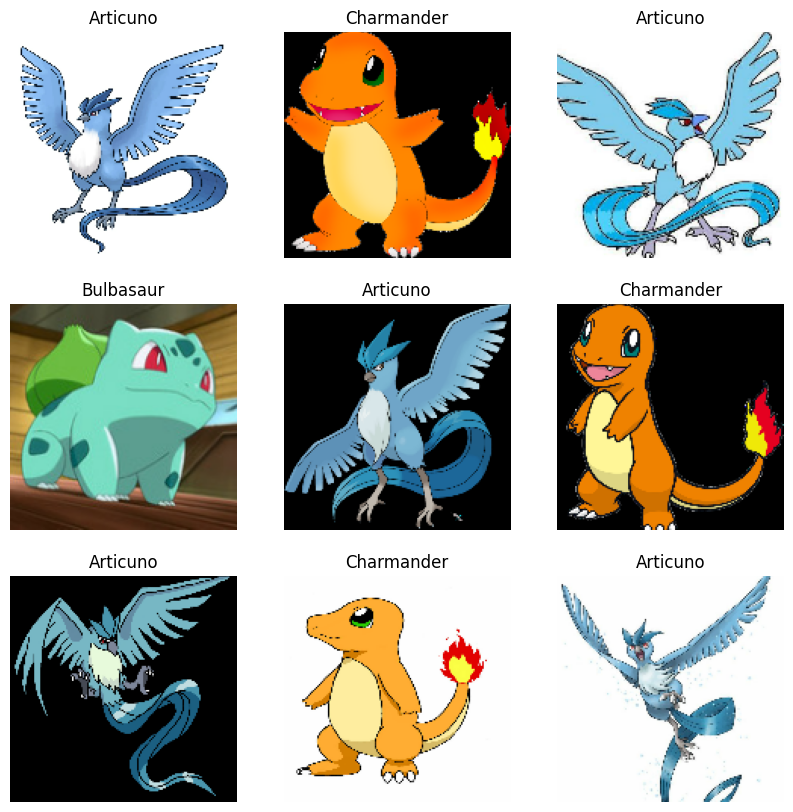

In [26]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
number_of_classes = len(train_ds.class_names)

In [28]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

## Using random data augmentation

In [29]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

2024-05-18 16:25:29.260702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:31.055127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


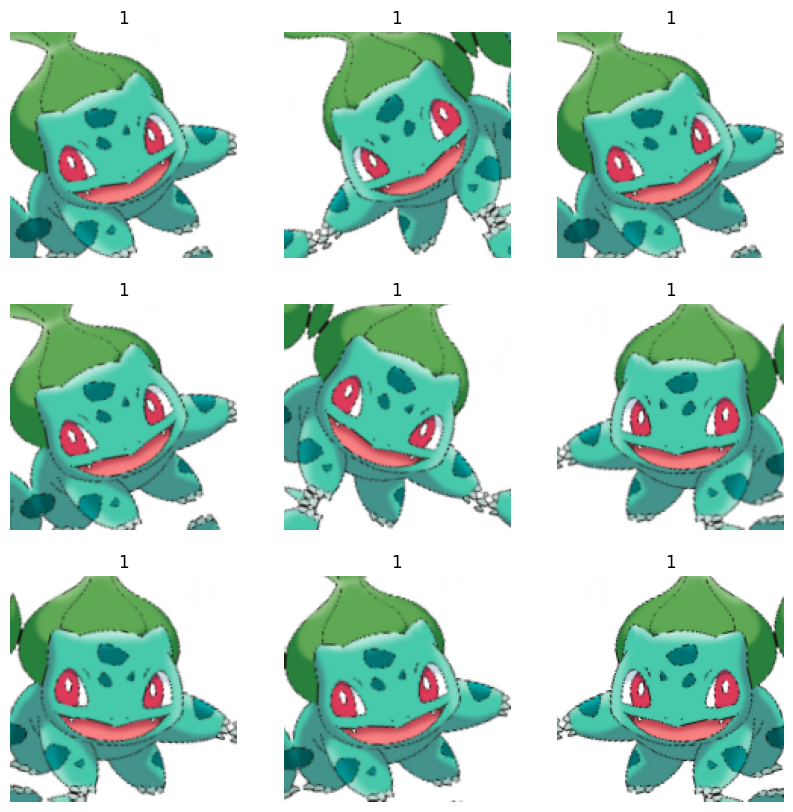

In [30]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# Data Augmentation

In [31]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_1 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [32]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4


2024-05-18 16:25:40.467764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4:27 9s/step - accuracy: 0.5833 - loss: 1.0137

2024-05-18 16:25:42.279155: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:42.303198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/32 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - accuracy: 0.5208 - loss: 1.0631

2024-05-18 16:25:43.191075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/32 ━━━━━━━━━━━━━━━━━━━━ 16s 553ms/step - accuracy: 0.4861 - loss: 1.0965

2024-05-18 16:25:43.510579: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/32 ━━━━━━━━━━━━━━━━━━━━ 16s 581ms/step - accuracy: 0.4635 - loss: 1.1270

2024-05-18 16:25:44.001969: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:44.002012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:25:44.236265: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/32 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step - accuracy: 0.4542 - loss: 1.1282

2024-05-18 16:25:45.576099: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:45.576132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 8/32 ━━━━━━━━━━━━━━━━━━━━ 13s 553ms/step - accuracy: 0.4586 - loss: 1.1206

2024-05-18 16:25:46.212847: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:46.217398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:46.218463: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6059 - loss: 0.8721

2024-05-18 16:25:58.587588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:58.587621: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:25:59.302359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:25:59.302447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:25:59.351233: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:00.061753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:01.320288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:01.565137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:03.049960: W tensorflow/core/lib/png/png_io.cc:89] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 983ms/step - accuracy: 0.6103 - loss: 0.8644 - val_accuracy: 0.9148 - val_loss: 0.2724
Epoch 2/4


2024-05-18 16:26:13.284790: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.9167 - loss: 0.2997

2024-05-18 16:26:14.984514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:15.016883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/32 ━━━━━━━━━━━━━━━━━━━━ 15s 521ms/step - accuracy: 0.9213 - loss: 0.2787

2024-05-18 16:26:15.869700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:16.140469: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/32 ━━━━━━━━━━━━━━━━━━━━ 14s 501ms/step - accuracy: 0.9149 - loss: 0.2874

2024-05-18 16:26:16.681874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:16.681908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:26:16.836222: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/32 ━━━━━━━━━━━━━━━━━━━━ 12s 486ms/step - accuracy: 0.9157 - loss: 0.2840

2024-05-18 16:26:18.118406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:18.118439: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 8/32 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - accuracy: 0.9171 - loss: 0.2820

2024-05-18 16:26:18.496730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:18.502834: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:18.504230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9262 - loss: 0.2428

2024-05-18 16:26:28.686734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:28.686803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:26:29.442201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:29.442242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:26:29.451553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:30.096082: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:31.502847: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:31.766453: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:33.249188: W tensorflow/core/lib/png/png_io.cc:89] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 916ms/step - accuracy: 0.9263 - loss: 0.2420 - val_accuracy: 0.9607 - val_loss: 0.1469
Epoch 3/4


2024-05-18 16:26:43.948045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - accuracy: 1.0000 - loss: 0.0816

2024-05-18 16:26:45.928382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:45.931361: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/32 ━━━━━━━━━━━━━━━━━━━━ 15s 543ms/step - accuracy: 0.9676 - loss: 0.1276

2024-05-18 16:26:46.858320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:47.158865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/32 ━━━━━━━━━━━━━━━━━━━━ 15s 549ms/step - accuracy: 0.9549 - loss: 0.1381

2024-05-18 16:26:47.711006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:47.711041: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:26:47.862687: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/32 ━━━━━━━━━━━━━━━━━━━━ 14s 564ms/step - accuracy: 0.9463 - loss: 0.1482

2024-05-18 16:26:49.227332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:49.227377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 8/32 ━━━━━━━━━━━━━━━━━━━━ 12s 541ms/step - accuracy: 0.9465 - loss: 0.1496

2024-05-18 16:26:49.691196: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:49.700958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:49.701474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9587 - loss: 0.1413

2024-05-18 16:26:59.728280: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:26:59.728321: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:27:00.486956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:00.487035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:27:00.509495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:01.191510: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:02.279517: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:02.496130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:04.348985: W tensorflow/core/lib/png/png_io.cc:89] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 874ms/step - accuracy: 0.9588 - loss: 0.1413 - val_accuracy: 0.9672 - val_loss: 0.1146
Epoch 4/4


2024-05-18 16:27:13.473418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 1.0000 - loss: 0.0765

2024-05-18 16:27:15.379646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:15.416965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/32 ━━━━━━━━━━━━━━━━━━━━ 16s 554ms/step - accuracy: 1.0000 - loss: 0.0804

2024-05-18 16:27:16.443296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:16.786610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/32 ━━━━━━━━━━━━━━━━━━━━ 15s 562ms/step - accuracy: 0.9896 - loss: 0.0997

2024-05-18 16:27:17.434325: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:17.434360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:27:17.579161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/32 ━━━━━━━━━━━━━━━━━━━━ 14s 566ms/step - accuracy: 0.9802 - loss: 0.1186

2024-05-18 16:27:19.051721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:19.052729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 8/32 ━━━━━━━━━━━━━━━━━━━━ 13s 575ms/step - accuracy: 0.9788 - loss: 0.1210

2024-05-18 16:27:19.435532: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:19.443489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:19.443859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9721 - loss: 0.1225

2024-05-18 16:27:30.114403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:30.114461: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:27:30.773470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:30.773509: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:27:30.781526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:31.359017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:32.416924: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:32.565125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:27:33.983588: W tensorflow/core/lib/png/png_io.cc:89] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 871ms/step - accuracy: 0.9721 - loss: 0.1222 - val_accuracy: 0.9803 - val_loss: 0.0873


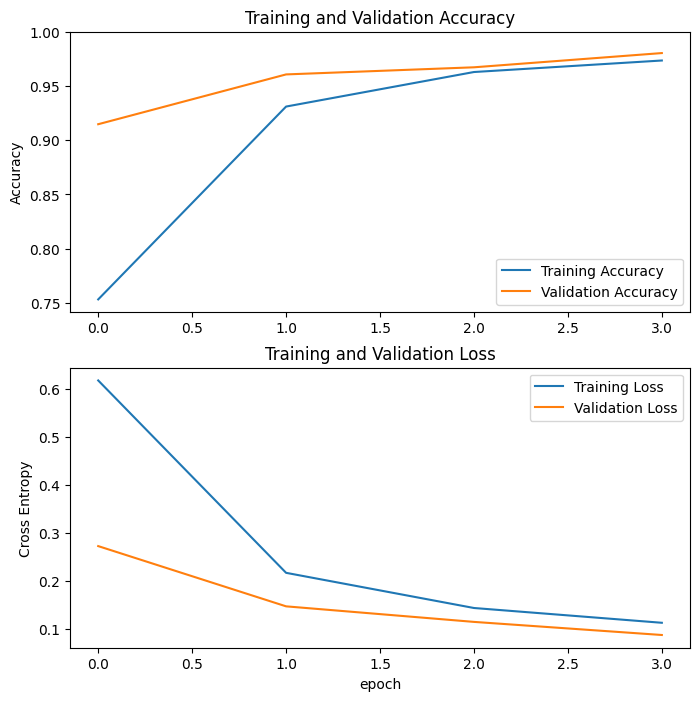

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_1 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,879,923 (79.65 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 12,296 (48.04 KB)

Fitting the end-to-end model


2024-05-18 16:28:12.936052: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:14.484406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:14.509534: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:15.440311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:15.727549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:16.314704: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:16.314739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/32 ━━━━━━━━━━━━━━━━━━━━ 17:22 34s/step - accuracy: 0.8333 - loss: 0.6249

2024-05-18 16:28:16.684571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7826 - loss: 0.6695 

2024-05-18 16:28:27.969064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:27.969097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 8/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7886 - loss: 0.6563

2024-05-18 16:28:32.057395: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:32.063150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:28:32.065421: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7675 - loss: 0.6571

2024-05-18 16:29:26.748691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:26.748726: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:29:27.395282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:27.395330: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:29:27.400640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:27.982119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:29.009295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:29.163878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:30.395242: W tensorflow/core/lib/png/png_io.cc:89] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.7685 - loss: 0.6559 - val_accuracy: 0.9836 - val_loss: 0.0827


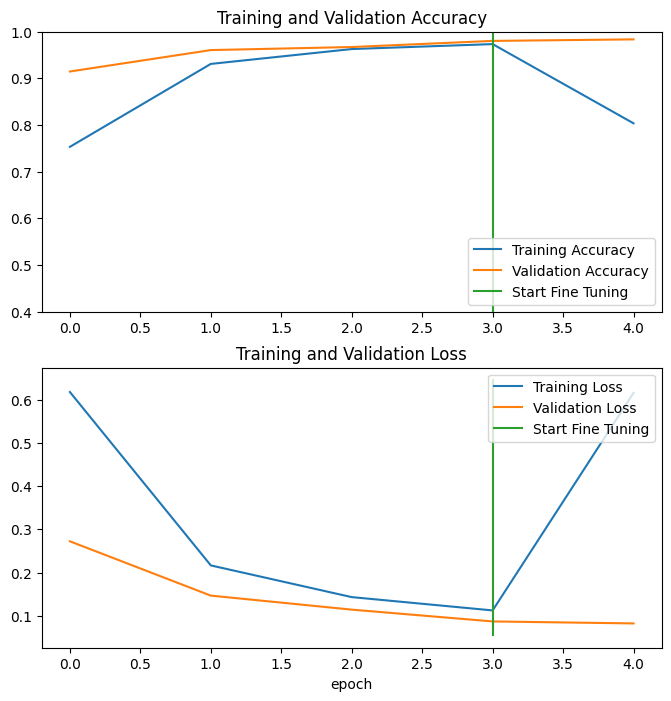

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation


2024-05-18 16:29:39.307467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:39.307513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:29:39.911247: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:39.911289: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:29:39.924753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/6 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - accuracy: 1.0000 - loss: 0.1155

2024-05-18 16:29:40.863339: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 1.0000 - loss: 0.0901


[0.07529465109109879, 1.0]

2024-05-18 16:29:42.569933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:42.569980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:29:43.293310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-18 16:29:43.293905: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-18 16:29:43.319504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


Predictions:
 [0 1 2 1 0 1 1 1 2 2 0 2]
Labels:
 [0 1 2 1 0 1 1 1 2 2 0 2]


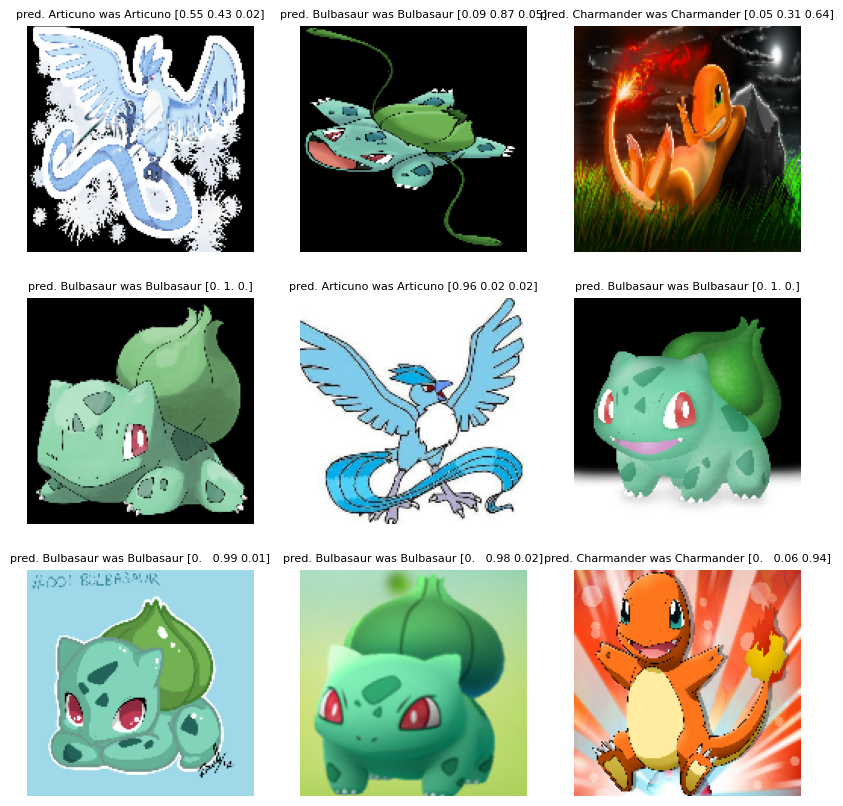

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [38]:
model.save('Pokemon-model_transferlearning.keras')